# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = False

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:

# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'supervised_nli_single_prompt_1_in_domain_restaurant_MNLI_base_seed_696'

# Random seed
random_seed = 696

# path to pretrained nli model folder or the string "textattack/bert-base-uncased-MNLI"
nli_model_path = "textattack/bert-base-uncased-MNLI"

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is good.",
    "The {aspect} is bad."]

#index of the prompts in the sentiment_prompts by polarity for later grouping
pos_prompt_indexes = [0]
neg_prompt_indexes = [1]

training_lm_freeze = False
#What datasets to be used for training and testing loops
testing_domain = "restaurants"

testing_batch_size = 32

In [3]:
# Parameters
experiment_id = "nli_zero_shot_laptops_MNLI-base_multi_prompt"
random_seed = 696
nli_model_path = "textattack/bert-base-uncased-MNLI"
sentiment_prompts = [
    "The {aspect} is good.",
    "The {aspect} is bad.",
    "I like the {aspect}.",
    "I dislike the {aspect}.",
    "The {aspect} made me feel good.",
    "The {aspect} made me feel bad.",
    "I felt the {aspect} was good.",
    "I felt the {aspect} was bad.",
]
pos_prompt_indexes = [0, 2, 4, 6]
neg_prompt_indexes = [1, 3, 5, 7]
testing_batch_size = 16
testing_domain = "laptops"
training_batch_size = 2


## Package imports

In [4]:
import sys
import os
import random
import shutil
import copy
import inspect

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy version: 1.20.2
PyTorch version: 1.8.1+cu111
Transformers version: 4.3.3


C:\Users\ibirl\.conda\envs\zero_shot\lib\site-packages\torch\__init__.py:421: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  warnings.warn((


## PyTorch GPU settings

In [5]:

if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.1
cuDNN Version: 8005
CUDA Device Name: GeForce RTX 2060
CUDA Capabilities: (7, 5)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [6]:
# Load semeval for both domains
laptop_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

restaurant_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache\sem_eval2014_task4_dataset\default-9b6d847dca00ea02\0.0.1\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache\sem_eval2014_task4_dataset\default-790c778f2f732468\0.0.1\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [7]:
dataset_dic_test = {
    "laptops": laptop_semeval_dataset['test'],
    "restaurants": restaurant_semeval_dataset['test']
}


In [8]:
# The dataset chosen for training and testing
test_set = dataset_dic_test[testing_domain]

## Load the pretrained LM

In [9]:
# Load pretrained language model
nli_model = transformers.AutoModelForSequenceClassification.from_pretrained(nli_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI", cache_dir='../bert_base_cache')

In [10]:
# Freeze all layers in lm.
if training_lm_freeze:
    for param in nli_model.parameters():
        param.requires_grad = False

In [11]:
classifier = utils.NLISentimentClassificationHead(
                    nli_model = nli_model,
                    num_prompts = len(sentiment_prompts),
                    pos_prompt_indexes = pos_prompt_indexes,
                    neg_prompt_indexes = neg_prompt_indexes
                    )
classifier.to(torch_device)

NLISentimentClassificationHead(
  (nli_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f

## Training settings

In [12]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

## Evaluation with in-domain test set

In [13]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [14]:

# Load the best found head weights
with torch.no_grad():

    classifier.eval()

    predictions_test = torch.Tensor().to(torch_device)

    labels_test = torch.Tensor().to(torch_device)

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for i in range(len(batch_test["text"])):
            
            for prompt in sentiment_prompts:
                reviews_repeated.append(batch_test["text"][i])
                prompts_populated.append(prompt.format(aspect=batch_test["aspect"][i]))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded.to(torch_device)

        nli_output = nli_model(**batch_encoded)["logits"]

        labels = batch_test["sentiment"]
        labels = labels.to(torch_device)
        
        outputs = classifier(batch_encoded)
        
        predictions_test = torch.cat([predictions_test, outputs])
        labels_test = torch.cat([labels_test, labels])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test.cpu(), labels_test.cpu())
    
    print(test_metrics)


{'accuracy': 0.5893416927899686, 'f1': 0.5466719439740287, 'precision': 0.7437195699100462, 'recall': 0.5764255066170388}


## Results visualization

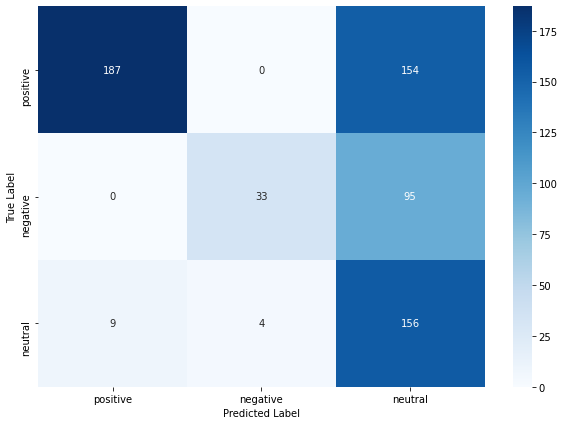

In [15]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy().argmax(-1), labels=[0,1,2])

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()